In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path

DATA_PATH = "/content/netflix_titles.xlsx"
df = pd.read_excel(DATA_PATH)

print("Rows, columns:", df.shape)
display(df.head())
df.columns = [c.strip() for c in df.columns]


Rows, columns: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25 00:00:00,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24 00:00:00,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24 00:00:00,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24 00:00:00,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24 00:00:00,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:

info = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "non_null_count": df.notna().sum().values,
    "null_count": df.shape[0] - df.notna().sum().values
})
display(info)


,column,dtype,non_null_count,null_count
show_id,show_id,object,8807,0
type,type,object,8807,0
title,title,object,8807,0
director,director,object,6173,2634
cast,cast,object,7982,825
country,country,object,7976,831
date_added,date_added,object,8797,10
release_year,release_year,int64,8807,0
rating,rating,object,8803,4
duration,duration,object,8804,3


In [3]:

def parse_date_added(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

df["date_added_parsed"] = df["date_added"].apply(parse_date_added)

def parse_duration(row):
    d = row.get("duration", None)
    if pd.isna(d):
        return pd.Series({"duration_min": np.nan, "duration_seasons": np.nan})
    d = str(d).strip()
    m = re.match(r"(\d+)\s*min", d, flags=re.I)
    if m:
        return pd.Series({"duration_min": int(m.group(1)), "duration_seasons": np.nan})
    m2 = re.match(r"(\d+)\s*Seas", d, flags=re.I)
    if m2:
        return pd.Series({"duration_min": np.nan, "duration_seasons": int(m2.group(1))})
    m3 = re.search(r"(\d+)", d)
    if m3:
        return pd.Series({"duration_min": int(m3.group(1)), "duration_seasons": np.nan})
    return pd.Series({"duration_min": np.nan, "duration_seasons": np.nan})

dur_parsed = df.apply(parse_duration, axis=1)
df = pd.concat([df, dur_parsed], axis=1)


movies = df[df["type"].str.lower() == "movie"].copy()
tv = df[df["type"].str.lower() == "tv show"].copy()
print("Total, movies, tv:", df.shape[0], movies.shape[0], tv.shape[0])


Total, movies, tv: 8807 6131 2676


,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


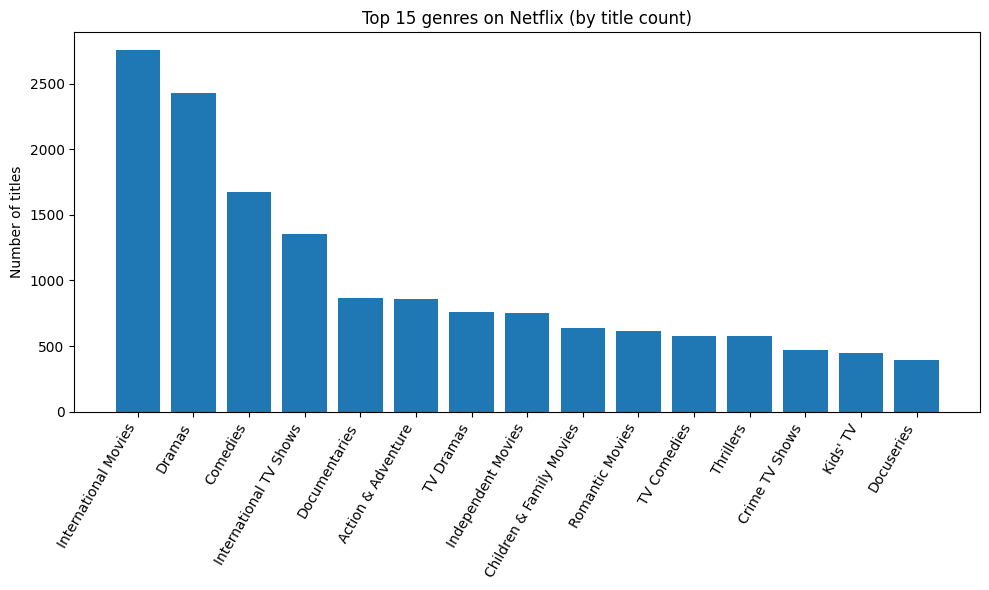

In [4]:

def explode_genres(df_in):
    s = df_in[["show_id", "title", "listed_in"]].copy()
    s["listed_in"] = s["listed_in"].fillna("Unknown")
    s = s.assign(listed_in=s["listed_in"].str.split(",")).explode("listed_in")
    s["listed_in"] = s["listed_in"].str.strip()
    return s

genres_exploded = explode_genres(df)
genre_counts = genres_exploded["listed_in"].value_counts().reset_index()
genre_counts.columns = ["genre", "count"]
display(genre_counts.head(30))


top_plot = genre_counts.head(15)
plt.figure(figsize=(10,6))
plt.bar(top_plot["genre"], top_plot["count"])
plt.xticks(rotation=60, ha="right")
plt.title("Top 15 genres on Netflix (by title count)")
plt.ylabel("Number of titles")
plt.tight_layout()
plt.show()


,release_year,count
0,1925,1
1,1942,2
2,1943,3
3,1944,3
4,1945,4
5,1946,2
6,1947,1
7,1954,2
8,1955,3
9,1956,2


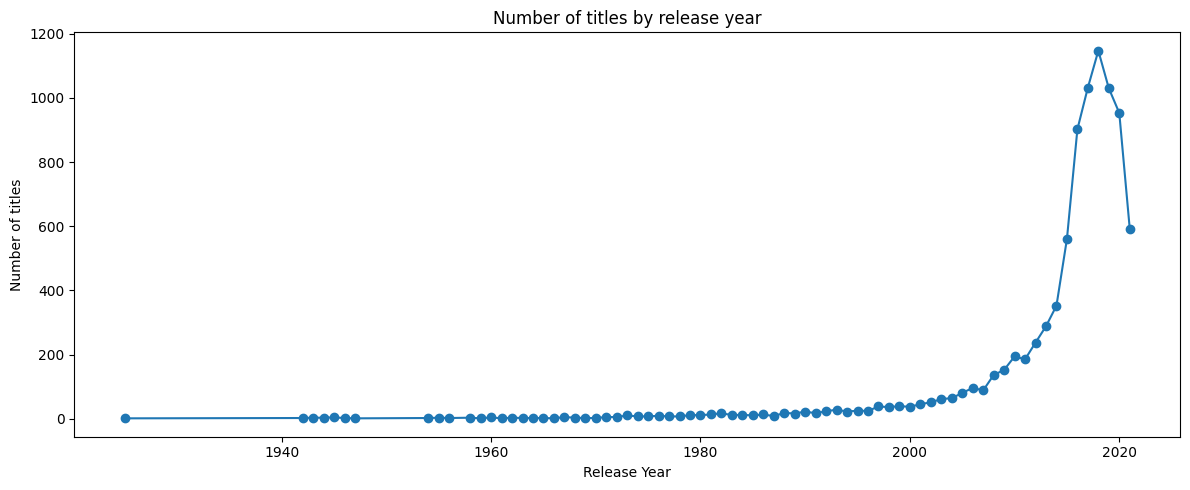

,year_added,count_added
0,2008,2
1,2009,2
2,2010,1
3,2011,13
4,2012,3
5,2013,11
6,2014,24
7,2015,82
8,2016,429
9,2017,1188


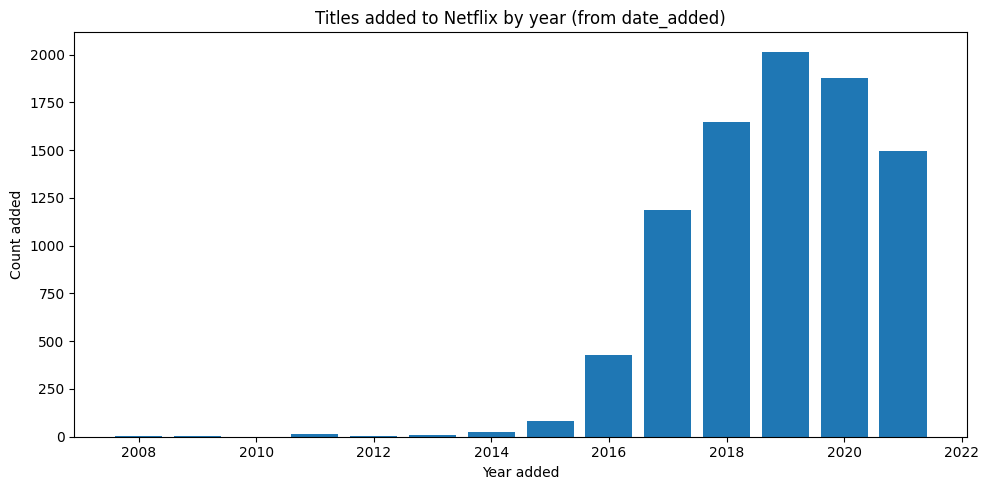

In [5]:

by_year = df["release_year"].value_counts().sort_index().reset_index()
by_year.columns = ["release_year", "count"]
display(by_year.head(40))

plt.figure(figsize=(12,5))
plt.plot(by_year["release_year"], by_year["count"], marker='o')
plt.title("Number of titles by release year")
plt.xlabel("Release Year")
plt.ylabel("Number of titles")
plt.tight_layout()
plt.show()


added = df.dropna(subset=["date_added_parsed"]).copy()
added["added_year"] = added["date_added_parsed"].dt.year
added_by_year = added["added_year"].value_counts().sort_index().reset_index()
added_by_year.columns = ["year_added", "count_added"]
display(added_by_year)

plt.figure(figsize=(10,5))
plt.bar(added_by_year["year_added"].astype(int), added_by_year["count_added"])
plt.title("Titles added to Netflix by year (from date_added)")
plt.xlabel("Year added")
plt.ylabel("Count added")
plt.tight_layout()
plt.show()


,rating_clean,num_titles,avg_duration_min,median_duration_min
11,TV-MA,2062,95.889913,96.0
9,TV-14,1427,110.290820,107.0
8,R,797,106.720201,103.0
12,TV-PG,540,94.851852,94.0
7,PG-13,490,108.330612,106.0
6,PG,287,98.282230,95.0
14,TV-Y7,139,66.287770,68.0
13,TV-Y,131,48.114504,46.0
10,TV-G,126,79.666667,84.0
5,NR,75,94.533333,90.0


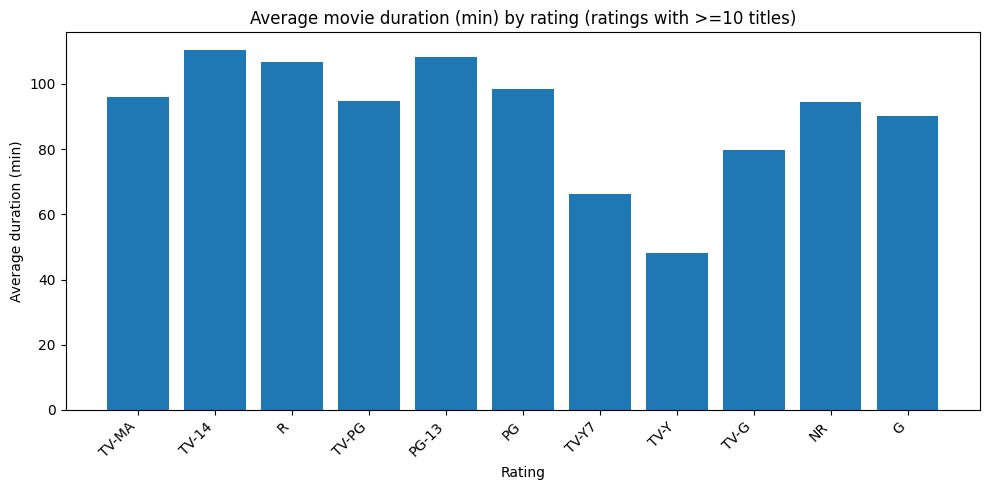

Pearson correlation release_year vs duration_min: -0.2062847468196562


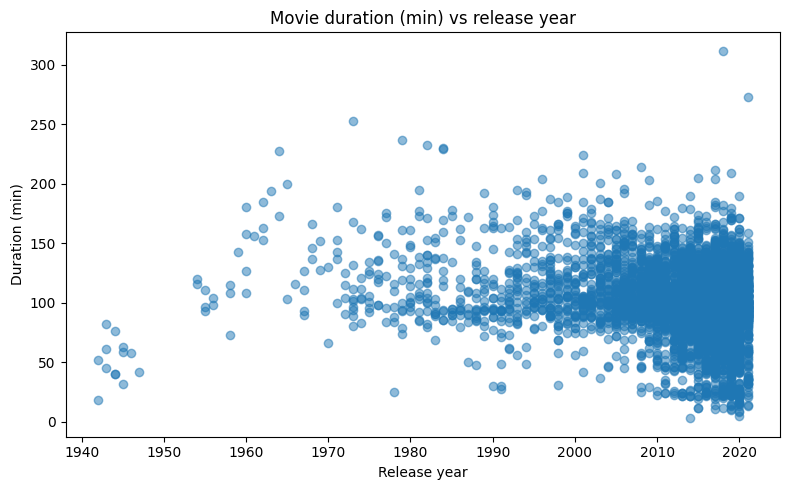

In [6]:


movies["rating_clean"] = movies["rating"].fillna("Unknown").astype(str).str.strip()
avg_duration_by_rating = movies.groupby("rating_clean")["duration_min"].agg(["count", "mean", "median"]).reset_index().sort_values("count", ascending=False)
avg_duration_by_rating = avg_duration_by_rating.rename(columns={"count":"num_titles", "mean":"avg_duration_min", "median":"median_duration_min"})
display(avg_duration_by_rating)

plot_df = avg_duration_by_rating[avg_duration_by_rating["num_titles"]>=10]
plt.figure(figsize=(10,5))
plt.bar(plot_df["rating_clean"], plot_df["avg_duration_min"])
plt.title("Average movie duration (min) by rating (ratings with >=10 titles)")
plt.xlabel("Rating")
plt.ylabel("Average duration (min)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

tmp = movies.dropna(subset=["duration_min", "release_year"])
corr = tmp["duration_min"].corr(tmp["release_year"])
print("Pearson correlation release_year vs duration_min:", corr)
plt.figure(figsize=(8,5))
plt.scatter(tmp["release_year"], tmp["duration_min"], alpha=0.5)
plt.title("Movie duration (min) vs release year")
plt.xlabel("Release year")
plt.ylabel("Duration (min)")
plt.tight_layout()
plt.show()


Top actors by degree centrality:
Anupam Kher 0.2765957446808511
Boman Irani 0.2553191489361702
Shah Rukh Khan 0.23404255319148937
Om Puri 0.23404255319148937
Kareena Kapoor 0.22340425531914893
Rajpal Yadav 0.22340425531914893
Amitabh Bachchan 0.2127659574468085
Jackie Shroff 0.2127659574468085
Akshay Kumar 0.20212765957446807
Paresh Rawal 0.20212765957446807
Anil Kapoor 0.20212765957446807
Naseeruddin Shah 0.18085106382978722
Salman Khan 0.18085106382978722
Asrani 0.18085106382978722
Mamoru Miyano 0.1702127659574468


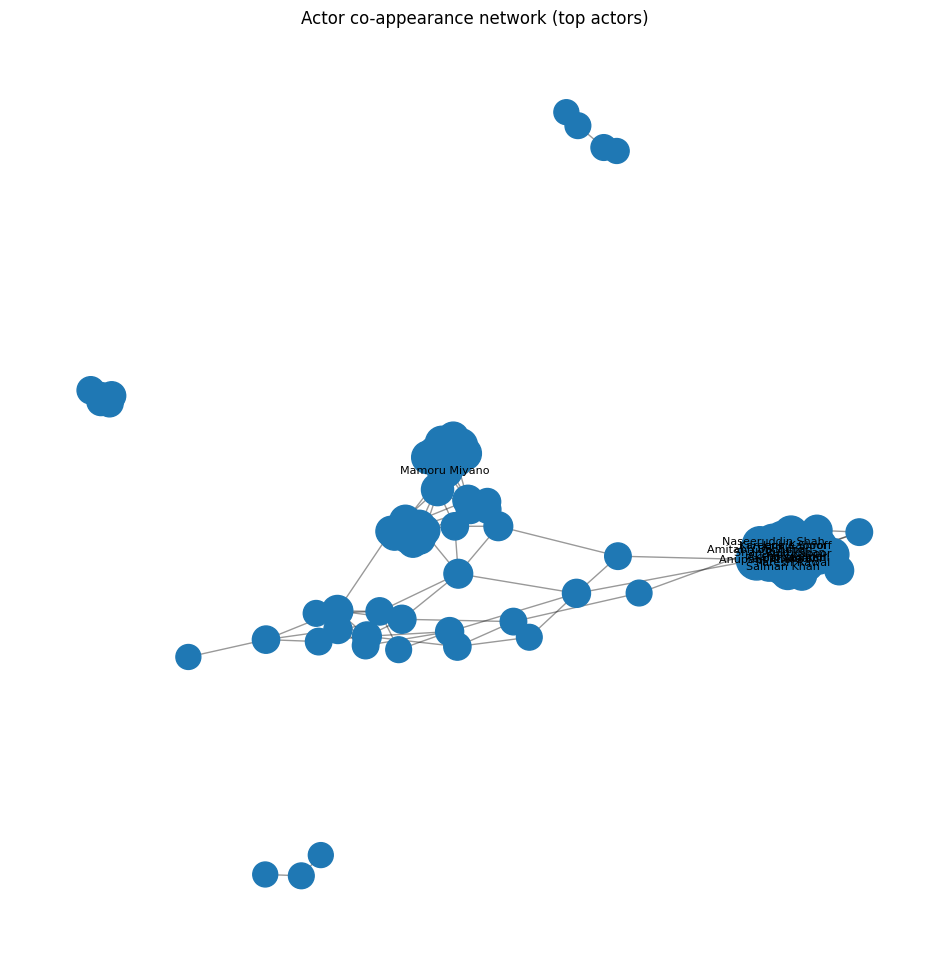

In [7]:

cast_series = df[["show_id", "title", "cast"]].dropna(subset=["cast"]).copy()

def split_cast(s):
    return [x.strip() for x in str(s).split(",") if x.strip()]

cast_series["cast_list"] = cast_series["cast"].apply(split_cast)

from collections import Counter
actor_counter = Counter()
for lst in cast_series["cast_list"]:
    actor_counter.update(lst)

top_actors = [actor for actor, cnt in actor_counter.most_common(100)]


G = nx.Graph()
G.add_nodes_from(top_actors)
for cast_list in cast_series["cast_list"]:
    present = [a for a in cast_list if a in top_actors]
    for i in range(len(present)):
        for j in range(i+1, len(present)):
            a = present[i]; b = present[j]
            if G.has_edge(a,b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a,b, weight=1)

isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

deg_cent = nx.degree_centrality(G)
sorted_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top actors by degree centrality:")
for actor, cval in sorted_deg:
    print(actor, cval)

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.15, iterations=80, seed=42)
node_sizes = [300 + 2000*deg_cent.get(n,0) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.4)
top_labels = {n:n for n, _ in sorted_deg[:30]}
nx.draw_networkx_labels(G, pos, labels=top_labels, font_size=8)
plt.title("Actor co-appearance network (top actors)")
plt.axis('off')
plt.show()


In [8]:
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>